# Introduction

# Spikes and Neurons


In [40]:
import bk.plot
import bk.load
import numpy as np

In [45]:
bk.load.current_session()
bk.load.rat
bk.load.day
bk.load.path
bk.load.session

neurons,metadata = bk.load.loadSpikeData(bk.load.path)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [53]:
states = bk.load.states()

In [55]:
bk.plot.rasterPlot(neurons[(metadata.Region == 'Hpc') & (metadata.Type == 'Pyr')],np.array([[0,5]]))

TypeError: '(slice(None, None, None), 0)' is an invalid key

<class 'numpy.ndarray'>


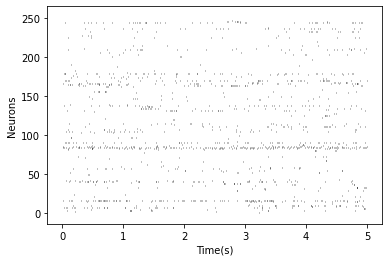

In [44]:
bk.plot.rasterPlot(neurons,window=np.array([[0,5]]))

In [21]:
states = bk.load.states()

In [23]:
for s in states: print(s)

Rem
sws
wake
drowsy


In [28]:
neurons[3].restrict(states['wake']).as_units('s')

Time (s)
1.10595       NaN
1.11175       NaN
1.11720       NaN
1.12520       NaN
1.46010       NaN
               ..
20659.38035   NaN
22477.91440   NaN
22491.20380   NaN
22559.19620   NaN
22623.17330   NaN
Name: 0, Length: 2595, dtype: float64

# LFPs

# Behavior

# Already done in  MATLAB

# Batching

# Conclusion